<a href="https://colab.research.google.com/github/ajmal92/datascience/blob/main/walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About Walmart

Walmart is an American multinational retail corporation that operates a chain of supercenters, discount departmental stores, and grocery stores from the United States. Walmart has more than 100 million customers worldwide.

### Business Problem

The Management team at Walmart Inc. wants to analyze the customer purchase behavior (specifically, purchase amount) against the customer’s gender and the various other factors to help the business make better decisions. They want to understand if the spending habits differ between male and female customers: Do women spend more on Black Friday than men? (Assume 50 million customers are male and 50 million are female

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

## Loading dataset

In [ ]:
sales = pd.read_csv("/Users/ajmal.m/Downloads/walmart_data.txt")
sales.head(3)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422


## EDA

In [ ]:
sales.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category',
       'Purchase'],
      dtype='object')

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [ ]:
sales.shape

(550068, 10)

In [ ]:
sales.isna().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

- There are 550068 rows and 10 columns
- There are no null values in any of the columns

In [ ]:
sales[sales.duplicated()]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase


#### Converting the column to lower case

In [ ]:
sales.columns = [col.lower() for col in sales.columns]

In [ ]:
sales.head(4)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057


- There are no duplicates in the data

#### Converting user_id,product_category from int to obj

In [ ]:
sales['product_category'] = sales['product_category'].astype(str)
sales['user_id'] = sales['user_id'].astype(str)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   user_id                     550068 non-null  object
 1   product_id                  550068 non-null  object
 2   gender                      550068 non-null  object
 3   age                         550068 non-null  object
 4   occupation                  550068 non-null  int64 
 5   city_category               550068 non-null  object
 6   stay_in_current_city_years  550068 non-null  object
 7   marital_status              550068 non-null  int64 
 8   product_category            550068 non-null  object
 9   purchase                    550068 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 42.0+ MB


#### How many users are there?

In [ ]:
sales['user_id'].nunique()

5891

#### How many products are there?

In [ ]:
sales['product_id'].nunique()

3631

#### Correlation between features

In [ ]:
sales.corr()

,user_id,occupation,marital_status,product_category,purchase
user_id,1.000000,-0.023971,0.020443,0.003825,0.004716
occupation,-0.023971,1.000000,0.024280,-0.007618,0.020833
marital_status,0.020443,0.024280,1.000000,0.019888,-0.000463
product_category,0.003825,-0.007618,0.019888,1.000000,-0.343703
purchase,0.004716,0.020833,-0.000463,-0.343703,1.000000


    - marital_status has a negative correlation with purchase. It could indicate that married customers purchase less compared to single customers
    - product category has a negative correlation with purchase. Products of higher category will be purchased less when compared to the products of lower category.

## Finding Outliers

In [ ]:
def find_outliers_rows(df, col, level='both'):
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]


In [ ]:
sales_numeric = sales.select_dtypes(include=['int', 'float'])
outlier_columns = [{'column':col, 'outlier_rows':len(find_outliers_rows(sales_numeric, col)), 'outlier_percentage':round(len(find_outliers_rows(sales_numeric, col))/550068,4)}  for col in sales_numeric.columns if len(find_outliers_rows(sales_numeric, col))]
pd.DataFrame(outlier_columns)

,column,outlier_rows,outlier_percentage
0,purchase,2677,0.0049


- product category and purchase column have outliers in their data with 0.0075% and 0.0049% respectively.
- Since the outliers are negligeable, the data will be used in the analysis

## Univariate Analysis

Text(0.5, 1.0, 'Outliers in Purchase')

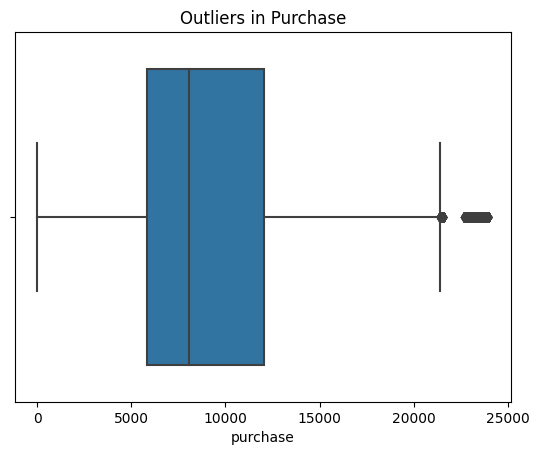

In [ ]:
sns.boxplot(data=sales, x='purchase')
plt.title('Outliers in Purchase')

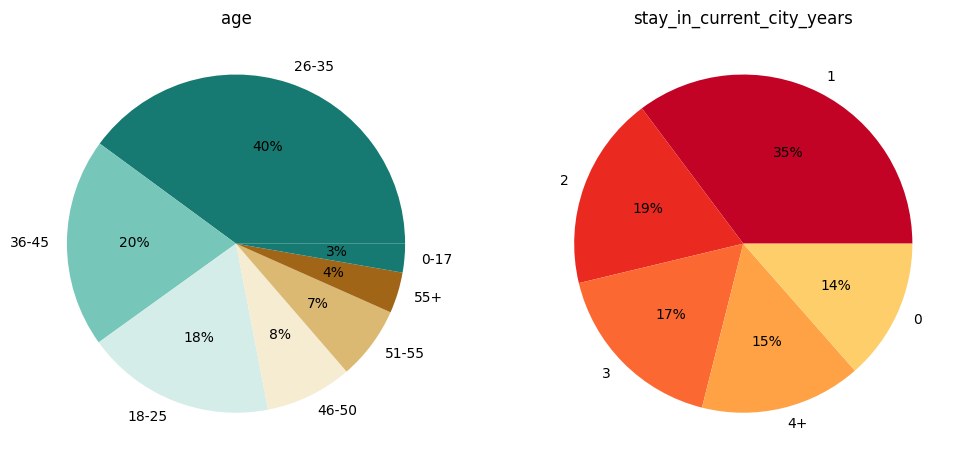

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

data = sales['age'].value_counts(normalize=True)*100
palette_color = sns.color_palette('BrBG_r')
axs[0].pie(x=data.values, labels=data.index, autopct='%.0f%%', colors=palette_color)
axs[0].set_title("age")

data = sales['stay_in_current_city_years'].value_counts(normalize=True)*100
palette_color = sns.color_palette('YlOrRd_r')
axs[1].pie(x=data.values, labels=data.index, autopct='%.0f%%', colors=palette_color)
axs[1].set_title("stay_in_current_city_years")


plt.show()

- Customers with age group 26-35 constitute 40% of the customers
- 35% of the customers have stay in current city years = 1

Text(0.5, 1.0, 'Product Category Frequency')

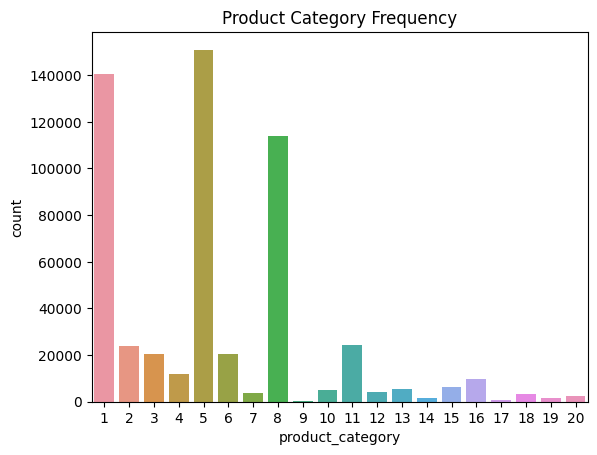

In [ ]:
sns.countplot(sales, x='product_category')
plt.title('Product Category Frequency')

- Product Category 0,5 and 8 have the highest frequency

### Summary Stats

In [ ]:
sales.describe()

,occupation,marital_status,purchase
count,550068.000000,550068.000000,550068.000000
mean,8.076707,0.409653,9263.968713
std,6.522660,0.491770,5023.065394
min,0.000000,0.000000,12.000000
25%,2.000000,0.000000,5823.000000
50%,7.000000,0.000000,8047.000000
75%,14.000000,1.000000,12054.000000
max,20.000000,1.000000,23961.000000


- max purchase value is 23961.000000 and min purchase value is 12.000000

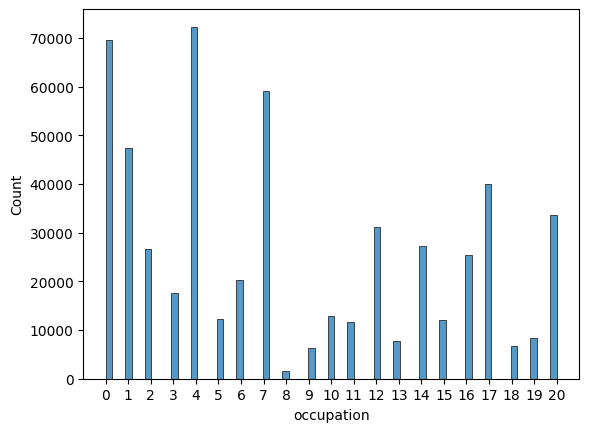

In [ ]:
sns.histplot(sales['occupation'])
plt.xticks(range(0, 21, 1))
plt.show()


- Maximum orders are from customers with occupation 4, 0 , 7 respectively

### Bi-Variate analysis

Text(0.5, 1.0, 'Age vs Purchase')

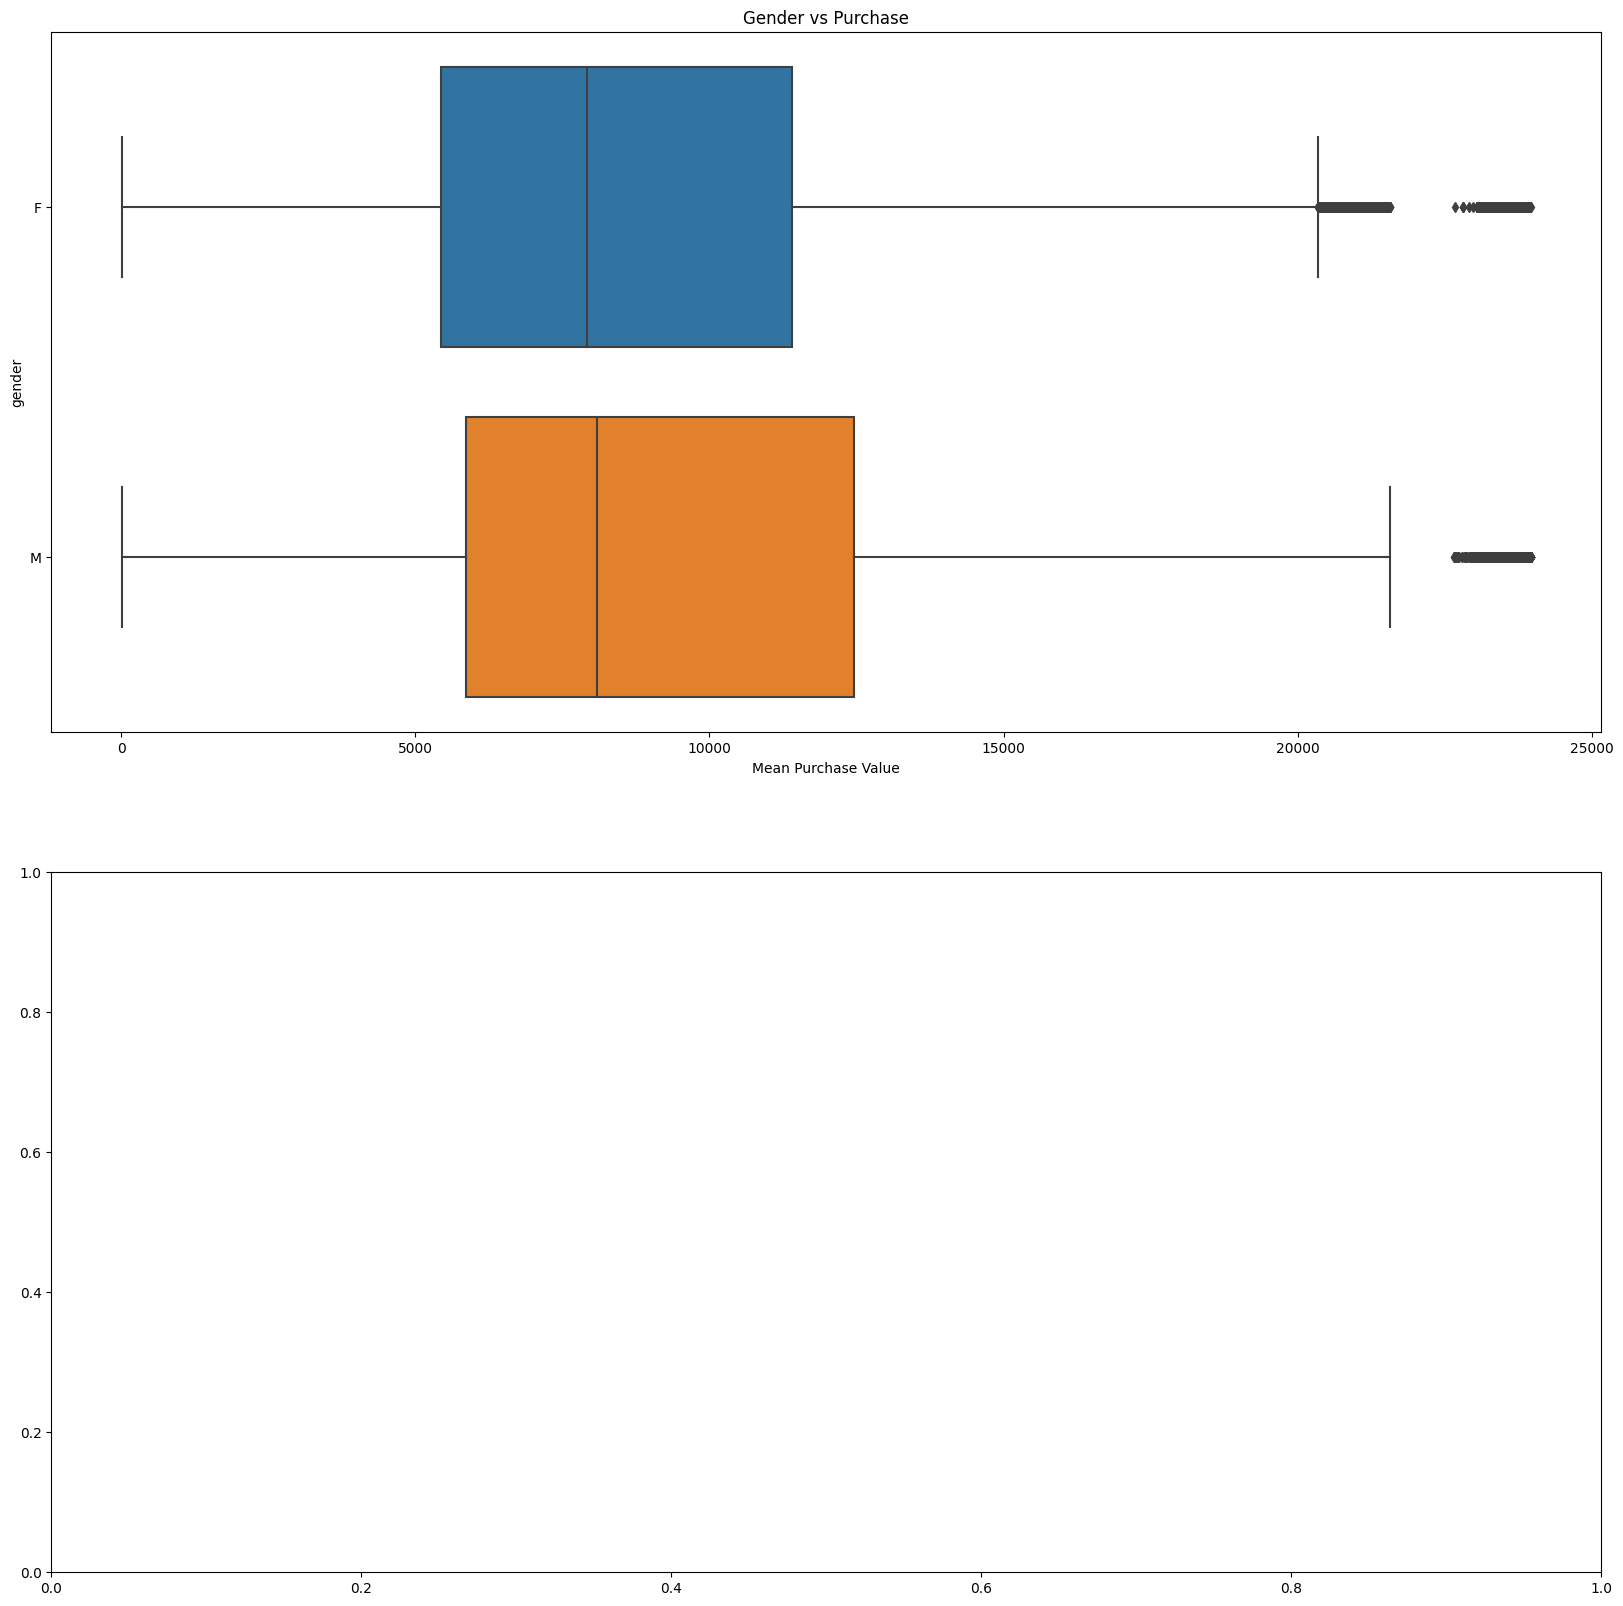

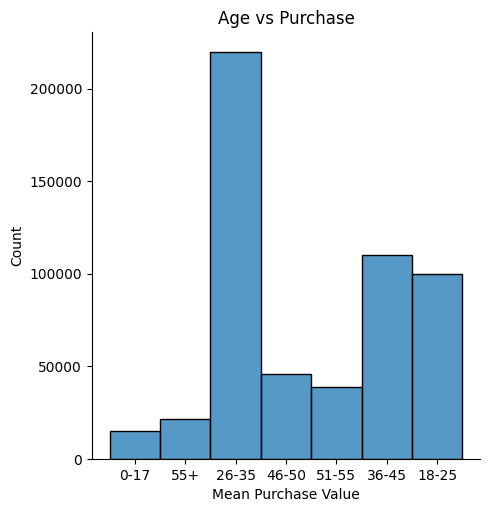

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2, 1, 1)

# sns.despine(left=True, ax=ax)

sns.boxplot(data=sales, x='purchase', y='gender')
plt.xlabel('Mean Purchase Value')
# plt.legend()
plt.title('Gender vs Purchase')

plt.subplot(2, 1, 2)

# sns.despine(left=True, ax=ax)
# plt.legend()
sns.displot(sales, x='age')
plt.xlabel('Mean Purchase Value')
plt.title('Age vs Purchase')






- Males tend to make higher purchases than female.
- Most of the orders are from the customers of age 26-35


<Axes: title={'center': 'gender'}, xlabel='purchase', ylabel='city_category'>

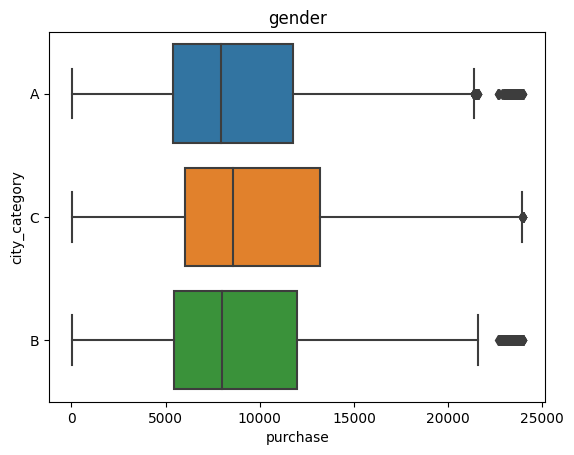

In [ ]:


sns.despine(left=True, ax=ax)
plt.xlabel('Mean Purchase Value')
# plt.legend()
plt.title('gender')
sns.boxplot(data=sales, x='purchase', y='city_category')



- Customers from city-category C spends the most

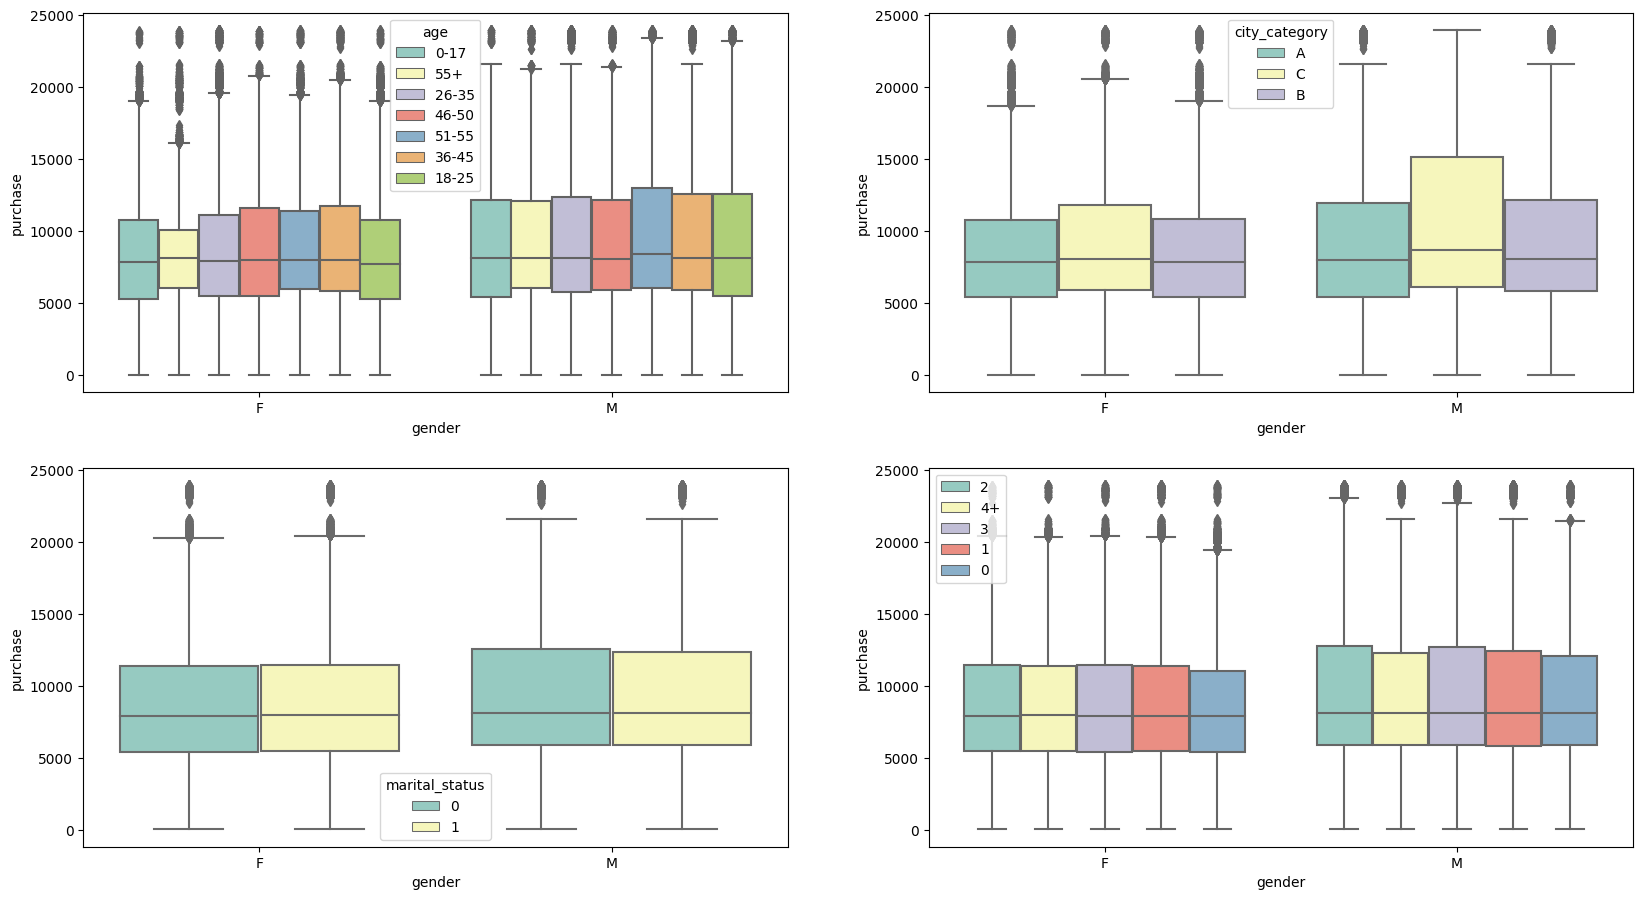

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))
fig.subplots_adjust(top=1.5)
sns.boxplot(data=sales, y='purchase', x='gender', hue='age', palette='Set3', ax=axs[0,0])
sns.boxplot(data=sales, y='purchase', x='gender', hue='city_category', palette='Set3', ax=axs[0,1])

sns.boxplot(data=sales, y='purchase', x='gender', hue='marital_status', palette='Set3', ax=axs[1,0])
sns.boxplot(data=sales, y='purchase', x='gender', hue='stay_in_current_city_years', palette='Set3', ax=axs[1,1])
axs[1,1].legend(loc='upper left')

- For female category, purchase ability is same for different years of stay in the same with an exception being new entries to the city.
- Among males, customers who are staying in the city for 2 years tend to spend big.
- In both male and female, the customers from City category C tend to spend the highest.
- In males, customers in the age group 51-55 spends the maximum.


## Population Estimation

In [ ]:
# num_bs = 1000
def get_z(confidence):
    alpha = (1+.95)/2
    return stats.norm.ppf(alpha)

def estimate(df, columns, confidence, num_bs_ls=(10000,)):
    output = {}
    
    z=get_z(confidence)
    df = df.groupby(by=columns)['purchase'].sum().reset_index()
    columns.remove('user_id')
    column = max(columns)
    
    for age in df[column].unique():
        mean_d = []
        for num_bs in num_bs_ls:
            sales_df = df.loc[df[column]==age]
            n = len(sales_df)
            means = [np.random.choice(a=sales_df['purchase'], size=n).mean() for i in range(num_bs)]
            mean = round(np.mean(means),2)
            std = np.round(np.std(means),2)
            mean_d.append(
                {
                           'mean':round(np.mean(means),2), 
                           'std':np.round(np.std(means),2), 
                           'sample_size':n,
                           'ci': (round(mean - (z*(stats.sem(np.array(means)))),2),round(mean + (z*(stats.sem(np.array(means)))),2)),
                           'emprical-SME': stats.sem(np.array(means)),
                            'all_means': means
                })
        output[age]=mean_d
    return output



### Estimation of Purchase for Male and Female


In [ ]:
output = estimate(df=sales, columns=['gender','user_id'] , confidence=.99)
male_ci = output['M'][0]['ci']
female_ci = output['F'][0]['ci']
print(f'Male CI - {male_ci}')
print(f'Female CI - {female_ci}')
arr_male = np.array(output['M'][0]['all_means'])
v_male = arr_male[(arr_male >= min(male_ci)) & (arr_male<=max(male_ci))]

arr_female = np.array(output['F'][0]['all_means'])
v_female = arr_female[(arr_female >= min(female_ci)) & (arr_female<=max(female_ci))]

Male CI - (925160.48, 925757.3)
Female CI - (711703.19, 712483.51)


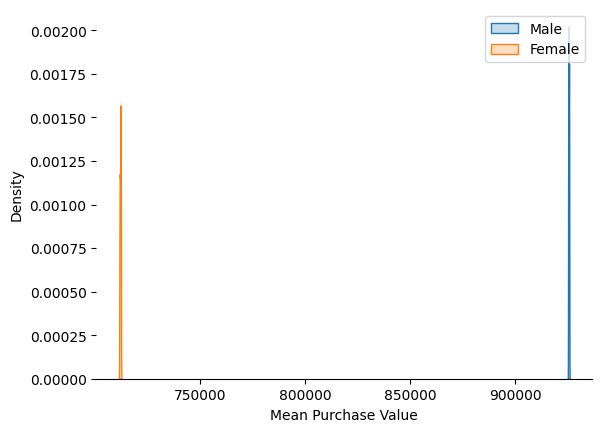

In [ ]:
# Create a plot to depict the mean purchase value for each gender
sns.kdeplot(v_male, fill=True, label='Male')
sns.kdeplot(v_female, fill=True, label='Female')
sns.despine(left=True)
plt.xlabel('Mean Purchase Value')
plt.legend()
plt.show()

#### 99% confidence mean purchase value for male and female

- Male - (925160.48, 925757.3)
- Female - (711703.19, 712483.51)

#### Inference
- With 99% confidence, we can infer that male tend to spend more than female.


### Population Estimate of Male and Female for different occupation category

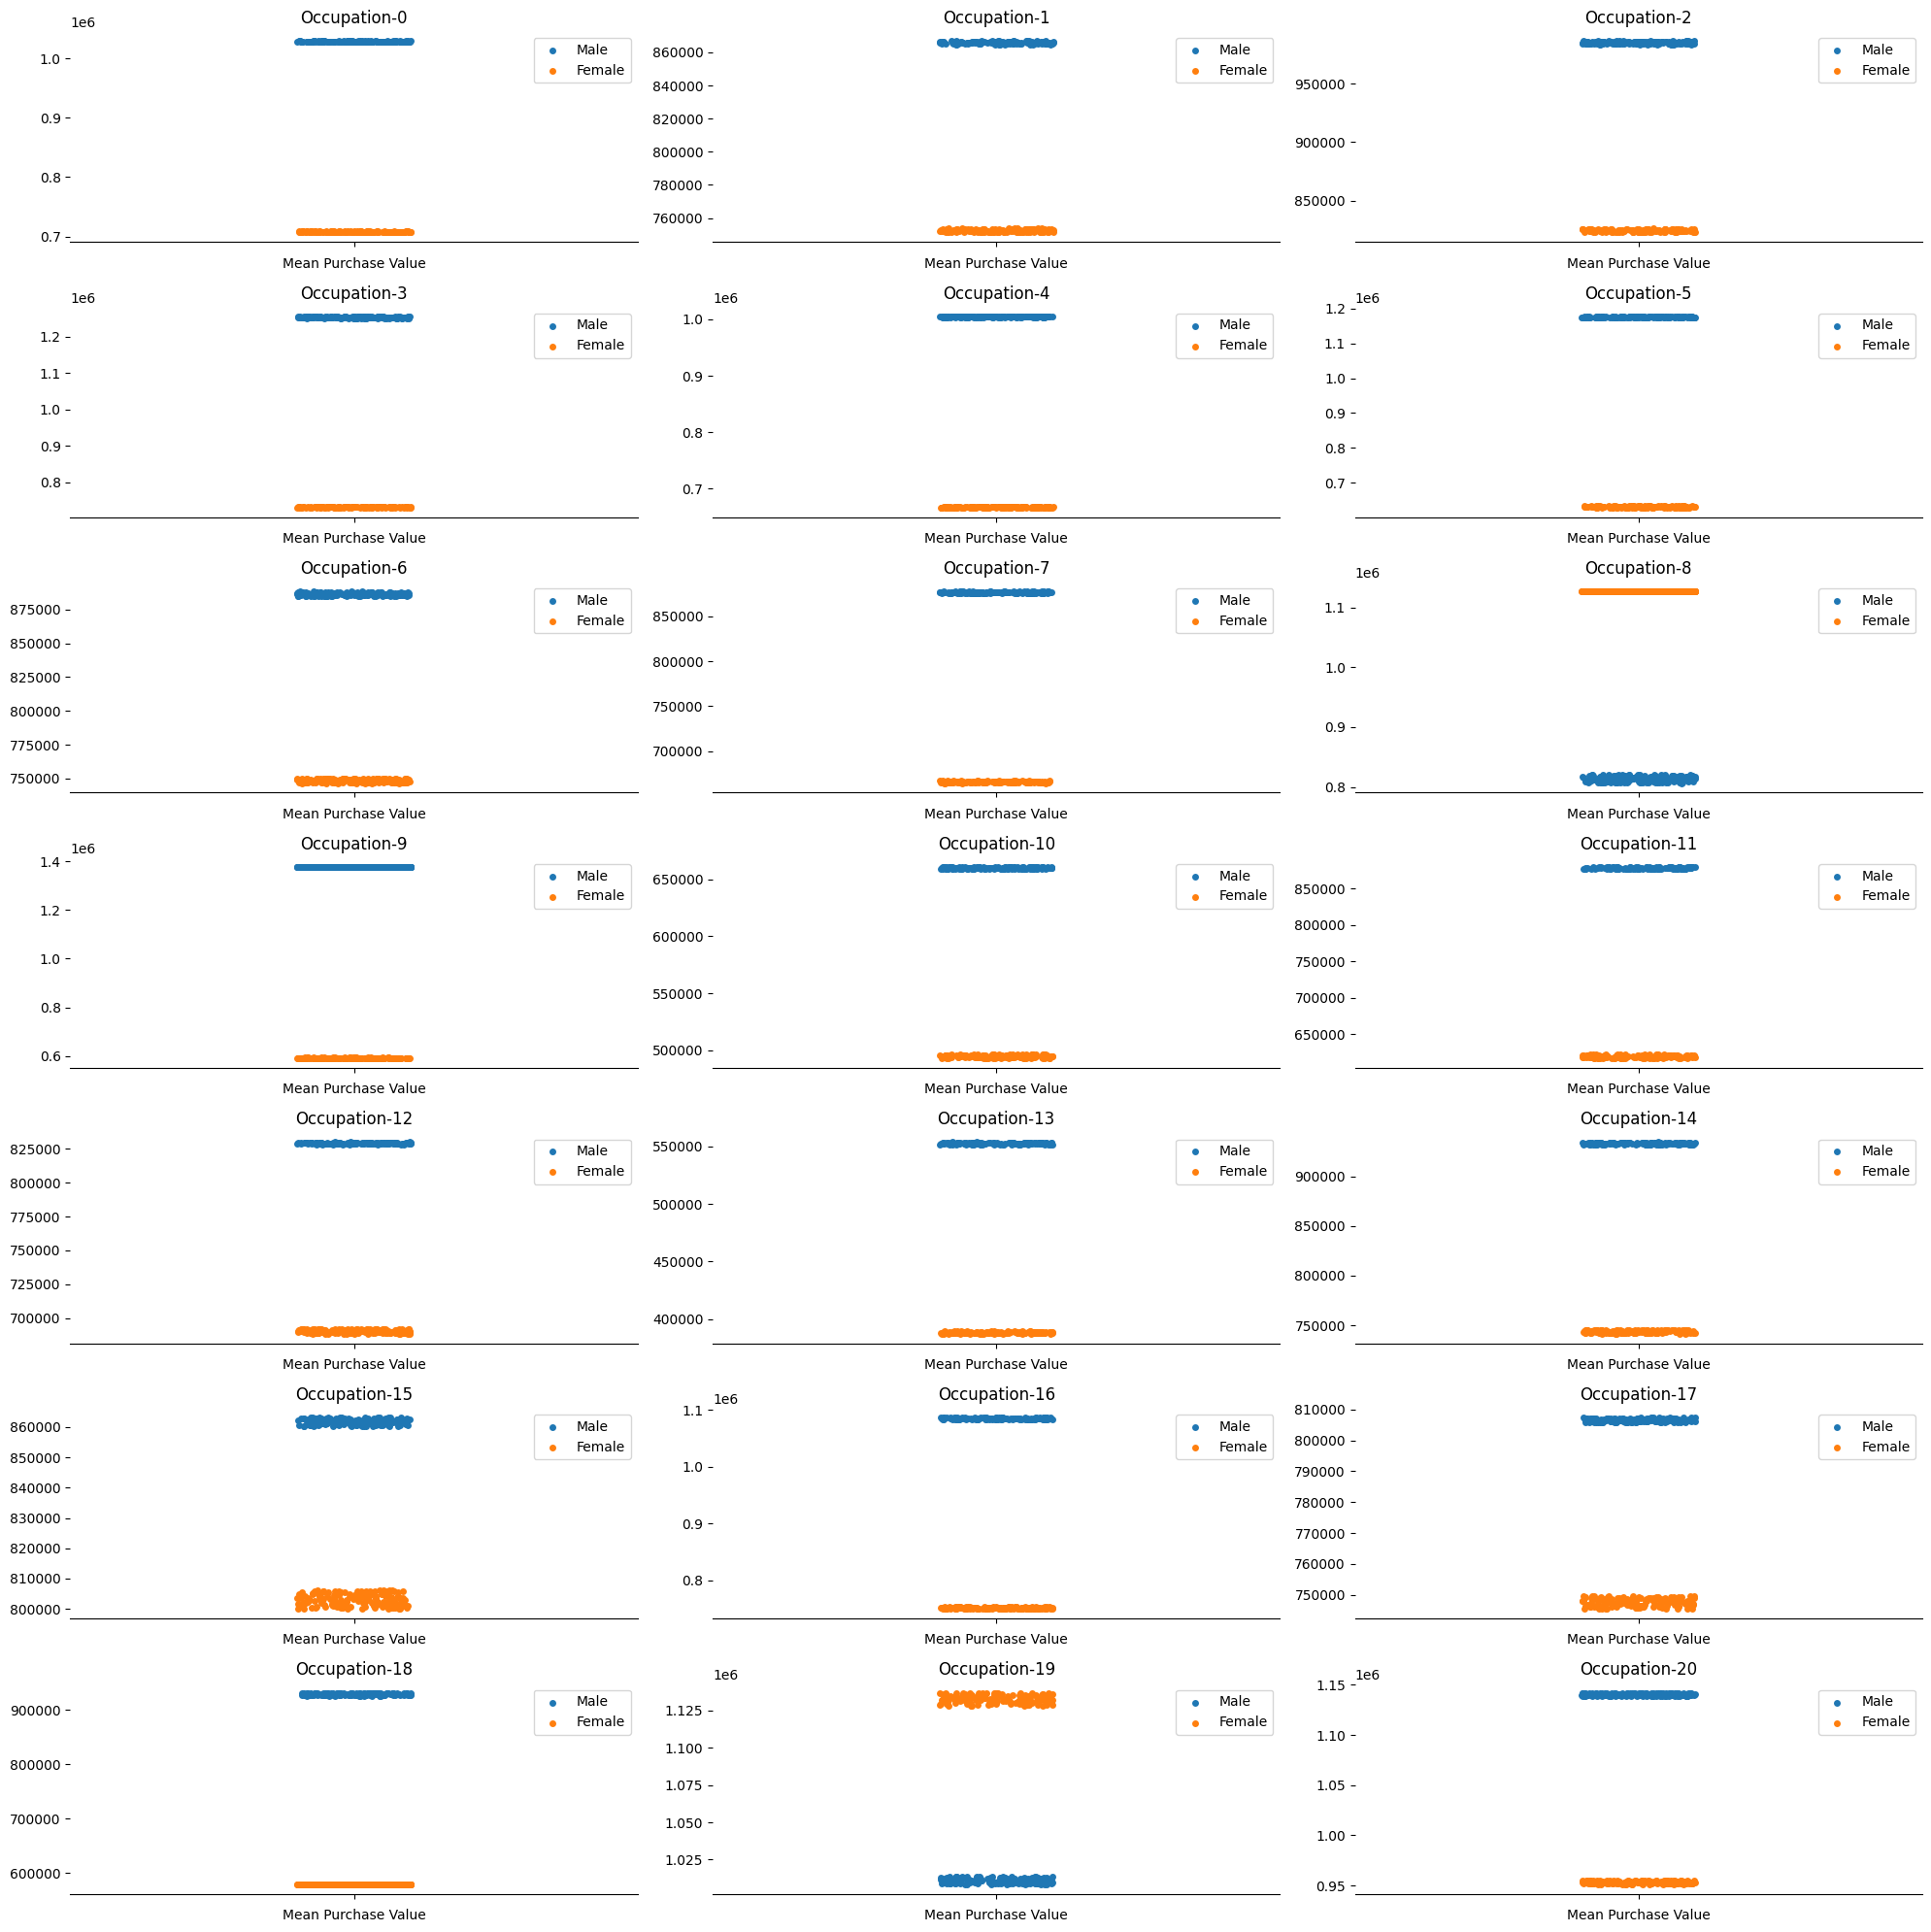

In [ ]:
plt.figure(figsize=(20,20))

num_cols = 3
num_rows = 7

for i in sales['occupation'].unique():
    df_city_2635=sales.groupby('occupation').get_group(i)
    op = estimate(df=df_city_2635, columns=['gender', 'user_id'],  confidence=0.95)
    male_ci = op['M'][0]['ci']
    female_ci = op['F'][0]['ci']
    arr_male = np.array(op['M'][0]['all_means'])
    arr_female = np.array(op['F'][0]['all_means'])
    
    v_male = arr_male[(arr_male >= min(male_ci)) & (arr_male<=max(male_ci))]
    v_female = arr_female[(arr_female >= min(female_ci)) & (arr_female<=max(female_ci))]
    
    
    row_num = i // num_rows
    col_num = i % num_cols
    
    ax = plt.subplot(num_rows, num_cols, i+1)
    sns.stripplot(v_male, label='Male', ax=ax)
    sns.stripplot(v_female, label='Female',  ax=ax)
    sns.despine(left=True, ax=ax)
    plt.xlabel('Mean Purchase Value')
    plt.legend()
    plt.title(f"Occupation-{i}")

plt.tight_layout()
plt.show()
 

- Male tend to spend more than female in most of the occupation categories
- In occupation 19 and 8, female spends more than male

### Population estimate of city_category vs purchase

A CI - (1258156.41, 1259837.61)
B CI - (1238625.65, 1239634.55)
C CI - (529849.09, 530148.83)


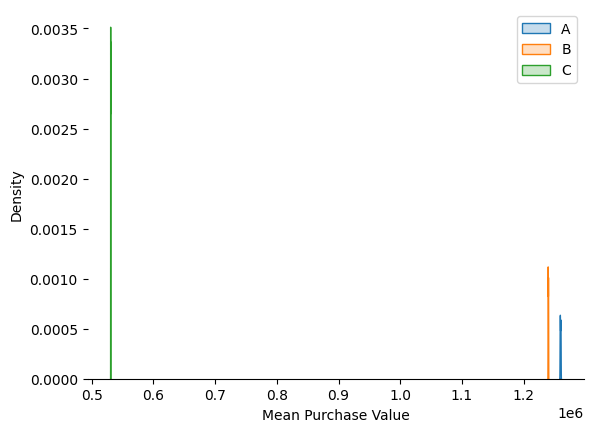

In [ ]:
output = estimate(df=sales, columns=['city_category','user_id'] , confidence=.99)
a_ci = output['A'][0]['ci']
b_ci = output['B'][0]['ci']
c_ci = output['C'][0]['ci']
print(f'A CI - {a_ci}')
print(f'B CI - {b_ci}')
print(f'C CI - {c_ci}')
arr_a = np.array(output['A'][0]['all_means'])
v_a = arr_a[(arr_a >= min(a_ci)) & (arr_a<=max(a_ci))]

arr_b = np.array(output['B'][0]['all_means'])
v_b = arr_b[(arr_b >= min(b_ci)) & (arr_b<=max(b_ci))]

arr_c = np.array(output['C'][0]['all_means'])
v_c = arr_c[(arr_c >= min(c_ci)) & (arr_c<=max(c_ci))]

sns.kdeplot(v_a, fill=True, label='A')
sns.kdeplot(v_b, fill=True, label='B')
sns.kdeplot(v_c, fill=True, label='C')
sns.despine(left=True)
plt.xlabel('Mean Purchase Value')
plt.legend()
plt.show()

99% Confidence Interval for Purchase mean for customers of different city category
- A CI - (1258156.41, 1259837.61)
- B CI - (1238625.65, 1239634.55)
- C CI - (529849.09, 530148.83)

#### Inference
- Customers from category A&B are the highest spenders
- Customers from category C are the lowest in purchase value

### Population Estimate of Martial_status vs Purchase

Married Customers CI - (843109.22, 843836.88)
Single Customers CI - (880173.84, 880813.62)


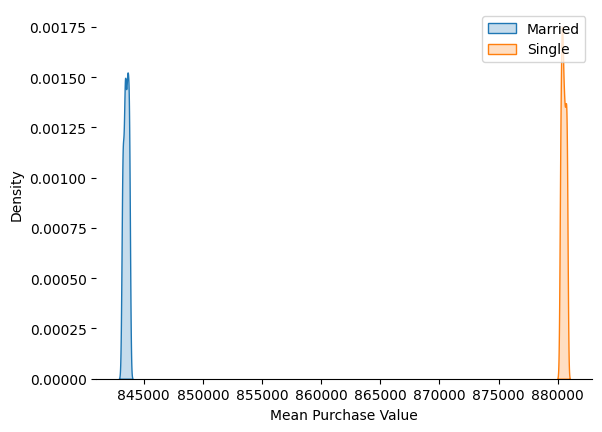

In [ ]:
output = estimate(df=sales, columns=['marital_status','user_id'] , confidence=.99)
a_ci = output[1][0]['ci']
b_ci = output[0][0]['ci']
print(f'Married Customers CI - {a_ci}')
print(f'Single Customers CI - {b_ci}')
arr_a = np.array(output[1][0]['all_means'])
v_a = arr_a[(arr_a >= min(a_ci)) & (arr_a<=max(a_ci))]

arr_b = np.array(output[0][0]['all_means'])
v_b = arr_b[(arr_b >= min(b_ci)) & (arr_b<=max(b_ci))]


sns.kdeplot(v_a, fill=True, label='Married')
sns.kdeplot(v_b, fill=True, label='Single')
sns.despine(left=True)
plt.xlabel('Mean Purchase Value')
plt.legend()
plt.show()

#### 99% confidence interval for purchase mean of married and single customers 
- married customers have mean purchase value in th range (780030.36, 799350.64)
- single customers have mean purchase value in th range (826157.53, 842220.31)

#### Inference
    - single customers tend to spend higher than married customers

In [ ]:
output = estimate(sales, columns=['age', 'user_id'], confidence=.95)
plot_output = {}
for age in sales['age'].unique():
    age_output = max(output[age])
    ci = age_output['ci']
    print(age, ci)
    arr = np.array(age_output['all_means'])
    v = arr[(arr >= min(ci)) & (arr<=max(ci))]
    plot_output[age]=v

#     sns.kdeplot(v2, fill=True, label='Single')

0-17 (618026.7438283262, 619844.9761716737)
55+ (539159.1096281682, 540423.2303718319)
26-35 (988827.853557777, 989708.446442223)
46-50 (791632.3228224295, 793227.7371775706)
51-55 (762798.7730747266, 764206.7869252735)
36-45 (879163.3180877615, 880295.1019122384)
18-25 (853842.938861254, 854907.341138746)


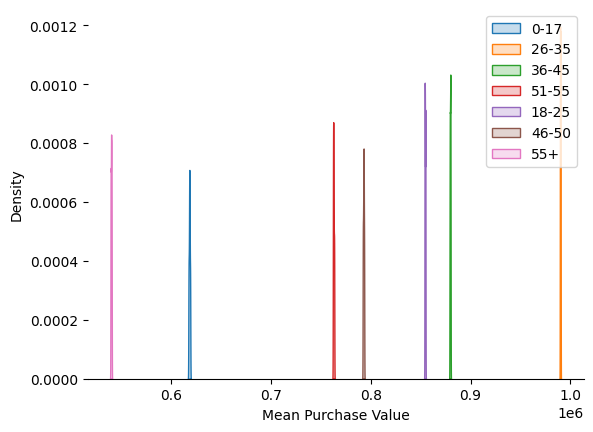

In [ ]:
sns.kdeplot(plot_output['0-17'], fill=True, label='0-17')
sns.kdeplot(plot_output['26-35'], fill=True, label='26-35')
sns.kdeplot(plot_output['36-45'], fill=True, label='36-45')
sns.kdeplot(plot_output['51-55'], fill=True, label='51-55')
sns.kdeplot(plot_output['18-25'], fill=True, label='18-25')
sns.kdeplot(plot_output['46-50'], fill=True, label='46-50')
sns.kdeplot(plot_output['55+'], fill=True, label='55+')
sns.despine(left=True)
plt.xlabel('Mean Purchase Value')
plt.legend()
plt.show()

#### 95% Confidence Intervals for different age groups
    - 0-17 (618026.7438283262, 619844.9761716737)
    - 55+ (539159.1096281682, 540423.2303718319)
    - 26-35 (988827.853557777, 989708.446442223)
    - 46-50 (791632.3228224295, 793227.7371775706)
    - 51-55 (762798.7730747266, 764206.7869252735)
    - 36-45 (879163.3180877615, 880295.1019122384)
    - 18-25 (853842.938861254, 854907.341138746)

#### Insights
    - Customers in the age category 26-35 tend to purchase the highest followed by 36-56 age category
    - Customers in the age category 55+ tend to purchase the least

### Population Estimate of Purchase mean with stay_in_current_city_years category

In [ ]:
output = estimate(df=sales, columns=['stay_in_current_city_years','user_id'] , confidence=.99)

a_ci = output['0'][0]['ci']
b_ci = output['1'][0]['ci']
c_ci = output['2'][0]['ci']
d_ci = output['3'][0]['ci']
e_ci = output['4+'][0]['ci']

print(f'stay_in_current_city_years- 0 -{a_ci}')
print(f'stay_in_current_city_years- 1 -{b_ci}')
print(f'stay_in_current_city_years- 2 -{c_ci}')
print(f'stay_in_current_city_years- 3 -{d_ci}')
print(f'stay_in_current_city_years- 4+-{e_ci}')

arr_a = np.array(output['0'][0]['all_means'])
v_a = arr_a[(arr_a >= min(a_ci)) & (arr_a<=max(a_ci))]

arr_b = np.array(output['1'][0]['all_means'])
v_b = arr_b[(arr_b >= min(b_ci)) & (arr_b<=max(b_ci))]

arr_c = np.array(output['2'][0]['all_means'])
v_c = arr_c[(arr_c >= min(c_ci)) & (arr_c<=max(c_ci))]

arr_d = np.array(output['3'][0]['all_means'])
v_d = arr_d[(arr_d >= min(d_ci)) & (arr_d<=max(d_ci))]

arr_e = np.array(output['4+'][0]['all_means'])
v_e = arr_d[(arr_d >= min(d_ci)) & (arr_d<=max(d_ci))]

sns.kdeplot(v_a, fill=True, label='0')
sns.kdeplot(v_b, fill=True, label='1')
sns.kdeplot(v_c, fill=True, label='2')
sns.kdeplot(v_d, fill=True, label='3')
sns.kdeplot(v_e, fill=True, label='4+')
sns.despine(left=True)
plt.xlabel('Mean Purchase Value')
plt.legend()
plt.tight_layout()
plt.show()

#### 99% confidence interval for mean of purchase values for stay_in_current_city_years

    - stay_in_current_city_years- 0 -(883937.29, 885380.53)
    - stay_in_current_city_years- 1 -(859094.53, 859904.65)
    - stay_in_current_city_years- 2 -(828352.58, 829348.34)
    - stay_in_current_city_years- 3 -(903497.72, 904760.92)
    - stay_in_current_city_years- 4+-(864166.24, 865410.9)

#### Inference
    - Customers living in the current city for 3 years are the highest spenders
    - Customers living in the current city for 2 years are the least spenders

## Insights and Recommendations

#### EDA
    - Males tend to make higher purchases than female.
    - Customers with age group 26-35 constitute 40% of the customers
    - 35% of the customers have stay in current city years = 1
    - For female category, purchase ability is same for different years of stay in the same with an exception being new entries to the city.
    - Among males, customers who are staying in the city for 2 years tend to spend big.
    - In both male and female, the customers from City category C tend to spend the highest.
    - In males, customers in the age group 51-55 spends the maximum.
    - Maximum orders are from customers with occupation 4, 0 , 7 respectively
    - - Product Category 0,5 and 8 have the highest frequency

### Based on Statistical Analysis (using CLT & CI)
    - With 99% confidence, we can infer that male tend to spend more than female.
    - Customers in the age category 26-35 tend to purchase the highest followed by 36-56 age category
    - Customers in the age category 55+ tend to purchase the least
    - single customers tend to spend higher than married customers
    - Customers from category A&B are the highest spenders
    - Customers from category C are the lowest in purchase value

### Recommendations
    - There should be offers and ads targetting more female audience to walmart.
    - Should target specific female audience who belong to occupation category 19 and 8 where they tend to spend more than male counterparts.
    - There should be city specific offers to attract more audience in city category C.
    - Spending power of 55+ and 0-17 age group is very. They should introduce games and books to attract younger audience.
    - They should also introduce more vintage products to target 55+ age audience 